# Assignment 3: Character-Level Recurrent Neural Network by PyTorch

In this assignment, you are required to implement Character-Level RNN just as we have learned in the class. However, the difference is we use another dataset in this assignment.

Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify names by their country of origin, which is introduced in the class. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on (notebook for Lecture 7), since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

The process will be broken down into the following steps:
>1. Code implementation. (20 marks)
2. Experimentation and analysis (80 marks)

In [3]:
!pip3 install scikit-learn

In [7]:
#Download and unzip files
# !pip3 install scikit-learn
# wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
# wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
# wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
# !sudo apt-get install unzip
# !unzip cities_val.zip 
# !unzip cities_train.zip 
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
#!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
# !pip3 install torch torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#Verfiy file download
# !head train/af.txt
# !printf "\n"
# !head val/af.txt
# !printf "\n"
# !head cities_test.txt
# !printf "\n"
#Verify CUDA acceleration should print cuda:0
# print(device)

## Code Implementation (20 marks)

**You should implement all the following functions and you are not allowed to delete any of them. Of course you can add more functions based on this skeleton.**

In [35]:
#main_classify.py
import codecs
import math
import random
import string
import time
import numpy as np
import torch
import unicodedata
from io import open
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_languages = len(languages)

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def getWords(baseDir, lang, train = True):
    if train:
        baseDir = baseDir + 'train'
    else:
        baseDir = baseDir + 'val'
    filename = baseDir +'/' + lang + '.txt'
    print("reading file:",filename)
    #Python strip() 方法用于移除字符串头尾指定的字符（默认为空格或换行符）
    words = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(word) for word in words]

#test getWords
# words = getWords('',languages[0])
# print(words)

'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    index = languages.index(lang)
    labels = np.zeros(length)
    labels[index] = 1
    
#     labels = [index]
    return labels

#test getLabels
# labels = getLabels(languages[0], len(languages))
# print(labels)#[1. 0. 0. 0. 0. 0. 0. 0. 0.]

'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    X = []
    y = []
    for i in range(0,len(languages)):
        X.append(getWords(baseDir,languages[i],train))
        y.append(languages[i])
    return X,y
#test  readData

train_X,train_y = readData('')
val_X,val_y = readData('',False)

# print(len(X))
# print(len(y))
# print(X[0])
# print(y[0])

'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def line_to_tensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

#test line_to_tensor
# tensor = line_to_tensor("Yang")
# print(tensor)
# print(tensor.shape) #[4, 1, 57]

'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    top_n, top_i = output.topk(1)
#     print("top_n",top_n)
#     print("top_i",top_i)
    language_i = top_i[0].item()
    return languages[language_i], language_i

'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair(X, y):
    language = randomChoice(y)
    language_index = y.index(language)
    line = randomChoice(X[language_index])
    language_tensor = torch.tensor([language_index],dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return language,line ,language_tensor,line_tensor
    
#test random_training_pair
# language,line ,language_tensor,line_tensor = random_training_pair(train_X,train_y)
# print(language)
# print(line)
# print(language_tensor)

'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
#输入：X是要预测的字符串，y是对应的标签
#输出：预测得到的前三个最高的类别
def predict(model, X, y):
    
    line_tensor = line_to_tensor(X)
    language_tensor = torch.tensor([languages.index(y)],dtype=torch.long)

    with torch.no_grad():
        hidden = model.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[i], hidden)

        language, language_index = category_from_output(output)
    
    return language


'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    count = 0
    num = 0
    for i in range(0,len(y)):
        num += len(X[i])
        for j in range(0,len(X[i])):
            language = predict(model,X[i][j],y[i])
            if (language == y[i]):
                count+=1
    acc = count/num
    print('There is %s samples,Accuracy=%s'%(num,acc))
    return acc

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion, optimizer, X, y):
    
    hidden = model.init_hidden()

    optimizer.zero_grad()
    
    for i in range(X.size()[0]):
        output, hidden = model(X[i], hidden)
        
    loss = criterion(output,y)
    loss.backward()

    optimizer.step()

    return output, loss.item()


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
def run(model,criterion):
    n_iters = 100000
    print_every = 5000
    plot_every = 1000
    
    current_loss = 0
    all_losses = []
    val_losses = []
    
    learning_rate = 0.005 
    
    start = time.time()
    
    for iter in range(1, n_iters + 1):
        language,line,language_tensor,line_tensor = random_training_pair(train_X,train_y)
        #trainOneEpoch(model, criterion, optimizer, X, y)
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
        output, loss = trainOneEpoch(model,criterion,optimizer,line_tensor,language_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == language else '✗ (%s)' % language
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, \
                                    timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            with torch.no_grad():
                hidden = model.init_hidden()
                language,line,language_tensor,line_tensor = random_training_pair(val_X,val_y)
                for i in range(line_tensor.size()[0]):
                    output_val, hidden = model(line_tensor[i], hidden)
                loss_val = criterion(output_val,language_tensor)
            val_losses.append(loss_val)
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    torch.save(model,'model_classify.pkl')
    return val_losses,all_losses


reading file: train/af.txt
reading file: train/cn.txt
reading file: train/de.txt
reading file: train/fi.txt
reading file: train/fr.txt
reading file: train/in.txt
reading file: train/ir.txt
reading file: train/pk.txt
reading file: train/za.txt
reading file: val/af.txt
reading file: val/cn.txt
reading file: val/de.txt
reading file: val/fi.txt
reading file: val/fr.txt
reading file: val/in.txt
reading file: val/ir.txt
reading file: val/pk.txt
reading file: val/za.txt


In [14]:
#models.py
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F

'''
Please add default values for all the parameters of __init__.
'''
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
criterion = nn.NLLLoss()
CharRnn = CharRNNClassify(n_letters, n_hidden, n_languages)

In [ ]:
val_losses,all_losses = run(CharRnn,criterion)

5000 5% (0m 14s) 1.8689 kisande / in ✗ (de)
10000 10% (0m 29s) 0.0817 hanock beza / za ✓
15000 15% (0m 45s) 0.2976 calves / fr ✓
20000 20% (1m 2s) 0.5197 sekamkhaza / za ✓
25000 25% (1m 19s) 0.1949 nzai / za ✓
30000 30% (1m 34s) 1.6833 taraf jundik / fi ✗ (af)
35000 35% (1m 50s) 3.0556 puebla de montalban / ir ✗ (de)
40000 40% (2m 6s) 0.7388 chirkingile / in ✓
45000 45% (2m 21s) 0.9957 shahrake mahdavi / ir ✓
50000 50% (2m 36s) 1.7547 huttenheim / de ✗ (fr)
55000 55% (2m 52s) 2.8963 chak eightyfour / fr ✗ (pk)
60000 60% (3m 7s) 0.1806 sal'miniulia / in ✓
65000 65% (3m 22s) 1.8561 la borie de bagas / de ✗ (fr)
70000 70% (3m 37s) 0.8360 nang inh / in ✓
75000 75% (3m 52s) 0.3329 spanzati / za ✓
80000 80% (4m 8s) 0.7742 tirma tid / ir ✓
85000 85% (4m 23s) 0.1394 lalizolle / fr ✓


## Experimentation and Analysis (80 marks)

Complete the following analysis on the city names dataset.

1. Write code to output accuracy on the validation set (10 marks).  Use a confusion matrix plot to support your answer (10 marks).

In [23]:
calculateAccuracy(CharRnn, train_X, train_y)        

There is %s samples,Accuracy=%s 27000 0.5212962962962963


0.5212962962962963

In [25]:
calculateAccuracy(CharRnn, val_X, val_y)  

There is 900 samples,Accuracy=0.48777777777777775


0.48777777777777775

E:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
E:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


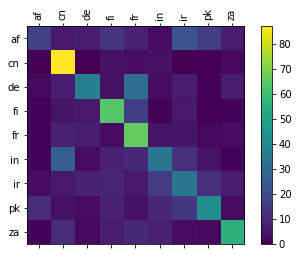

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

confusion = torch.zeros(n_languages, n_languages)

for i in range(0,len(val_y)):
    for j in range(0,len(val_X[i])):
        guess = predict(CharRnn,val_X[i][j],val_y[i])
        language_i = languages.index(val_y[i])
        guess_i = languages.index(guess)
        confusion[language_i][guess_i] += 1
                
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

2. Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses (20 marks).

E:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


AttributeError: 'Line2D' object has no property 'colors'

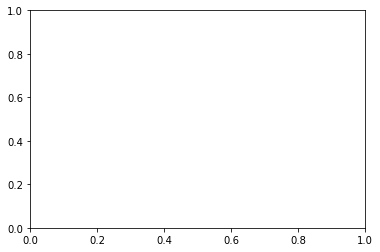

In [33]:
plt.figure()
plt.plot(all_losses,color='b')
plt.plot(val_losses,color='r')

3. Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss (20 marks).

4. Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy (20 marks)?